In [1]:
import keras
from keras.models import Sequential
from keras.layers import Rescaling
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Resizing, RandomHeight, RandomWidth, RandomZoom, RandomFlip, RandomRotation, RandomCrop, RandomTranslation, RandomContrast
from keras import backend as K
from keras.utils.vis_utils import plot_model
 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

# visualize model
import visualkeras
from PIL import ImageFont

print(K._get_available_gpus())


[]


In [2]:
batch_size = 32
num_classes = 5
epochs = 20

# path: save model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'coral_reef_cnn.h5'

# path for inputs
path = os.getcwd() + '/data/clean/split/on-func/'
train_folder = path + 'train'
test_folder = path + 'test'
val_folder = path + 'valid'


In [3]:

# train dataset
train_ds = keras.utils.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(100, 100),
    batch_size = batch_size,
    shuffle=True
)

# test dataset
test_ds = keras.utils.image_dataset_from_directory(
    test_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(100, 100),
    batch_size = batch_size,
    shuffle=True
)

# val dataset
val_ds = keras.utils.image_dataset_from_directory(
    val_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(100, 100),
    batch_size = batch_size,
    shuffle=True
)

class_names = train_ds.class_names
print(class_names)


Found 7000 files belonging to 5 classes.
Found 2550 files belonging to 5 classes.
Found 450 files belonging to 5 classes.
['Algae', 'Hard Coral', 'Other', 'Other Invertebrates', 'Soft Coral']


In [4]:
# Create preprocessing layers
out_height, out_width = 128,256
resize = Resizing(out_height, out_width)
height = RandomHeight(0.3)
width = RandomWidth(0.3)
zoom = RandomZoom(0.3)
 
flip = RandomFlip("horizontal_and_vertical")
rotate = RandomRotation(0.2)
crop = RandomCrop(out_height, out_width)
translation = RandomTranslation(height_factor=0.2, width_factor=0.2)
 
contrast = RandomContrast(0.2)

# normalization layer -> rescaling rgb img in range [0,1]
normalization = Rescaling(1./255)

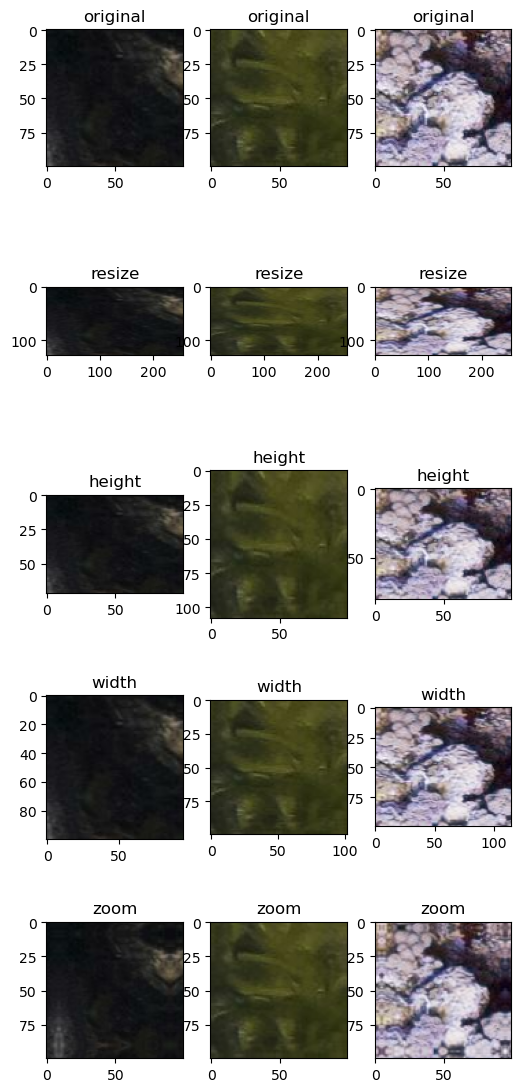

In [5]:
# Visualize images and augmentations
fig, ax = plt.subplots(5, 3, figsize=(6,14))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # resize
        ax[1][i].imshow(resize(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("resize")
        # height
        ax[2][i].imshow(height(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("height")
        # width
        ax[3][i].imshow(width(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("width")
        # zoom
        ax[4][i].imshow(zoom(images[i]).numpy().astype("uint8"))
        ax[4][i].set_title("zoom")
plt.show()

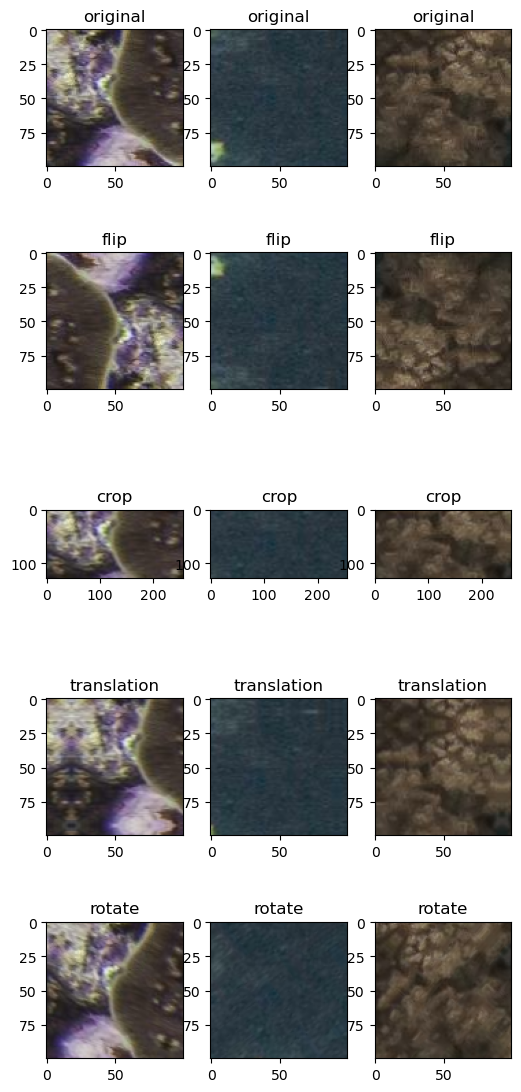

In [6]:
fig, ax = plt.subplots(5, 3, figsize=(6,14))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # flip
        ax[1][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("flip")
        # crop
        ax[2][i].imshow(crop(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("crop")
        # translation
        ax[3][i].imshow(translation(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("translation")
        # rotate
        ax[4][i].imshow(rotate(images[i]).numpy().astype("uint8"))
        ax[4][i].set_title("rotate")
plt.show()

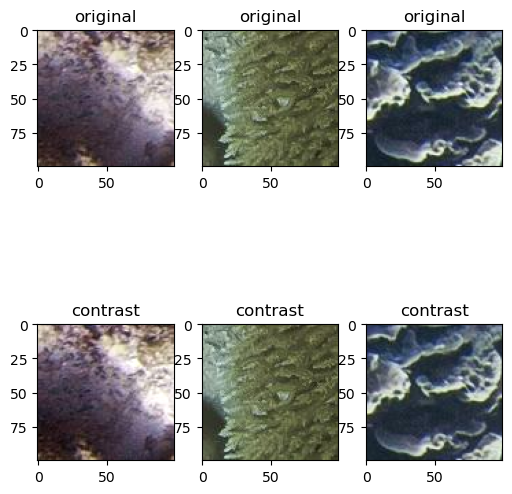

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(6,7))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # contrast
        ax[1][i].imshow(contrast(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("contrast")

In [16]:
#train_ds_norm = train_ds.map(lambda x, y: (normalization_layer(x), y))
#test_ds_norm = test_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds_norm = val_ds.map(lambda x, y: (normalization_layer(x), y))

def augment(image, label):
    return normalization(flip(contrast(image))), label
 
augment_train_ds = train_ds.map(augment)
augment_test_ds = test_ds.map(augment)
augment_val_ds = val_ds.map(augment)

In [17]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(100,100,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))       
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.35))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model


In [18]:
model = cnn_model()
model.summary()
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                        

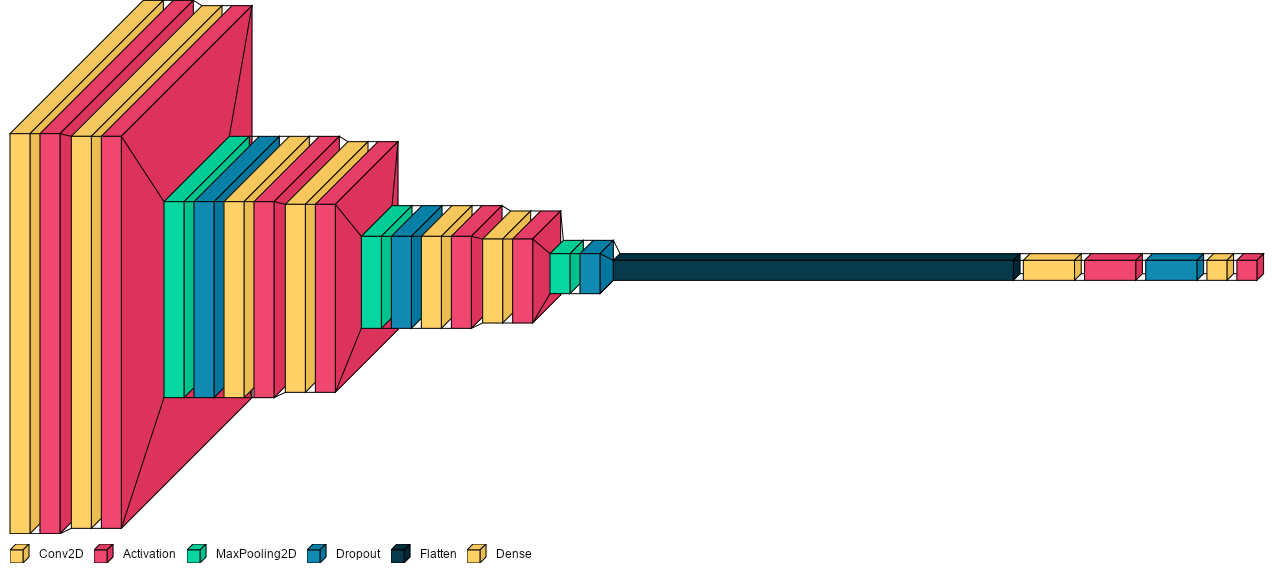

In [19]:
# visualize the model
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font, spacing=10)

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

# metrics
metrics = ['accuracy',
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall')
           ]

# compile
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=metrics)


In [26]:
history = model.fit(augment_train_ds,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(augment_test_ds),
                    shuffle=True)


Epoch 1/20
219/219 [==============================] - 39s 176ms/step - loss: 1.4497 - accuracy: 0.3293 - precision: 0.7551 - recall: 0.0899 - val_loss: 1.3927 - val_accuracy: 0.3706 - val_precision: 0.7423 - val_recall: 0.1129
Epoch 2/20
219/219 [==============================] - 37s 170ms/step - loss: 1.3759 - accuracy: 0.3716 - precision: 0.7471 - recall: 0.1207 - val_loss: 1.3605 - val_accuracy: 0.3839 - val_precision: 0.7525 - val_recall: 0.1180
Epoch 3/20
219/219 [==============================] - 39s 177ms/step - loss: 1.3470 - accuracy: 0.3956 - precision: 0.7277 - recall: 0.1306 - val_loss: 1.3834 - val_accuracy: 0.3776 - val_precision: 0.8416 - val_recall: 0.0729
Epoch 4/20
219/219 [==============================] - 38s 175ms/step - loss: 1.3163 - accuracy: 0.4141 - precision: 0.7374 - recall: 0.1444 - val_loss: 1.3514 - val_accuracy: 0.3878 - val_precision: 0.7818 - val_recall: 0.1110
Epoch 5/20
219/219 [==============================] - 39s 176ms/step - loss: 1.3041 - accura

KeyboardInterrupt: 

In [8]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

#print(history.history)


Saved trained model at c:\Users\eric_\Documents\GitHub\fruitpunch_coral_classification\saved_models\coral_reef_cnn.h5 


In [9]:
score = model.evaluate(val_ds_norm, verbose=1)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


15/15 [==============================] - 1s 44ms/step - loss: 1.5641 - accuracy: 0.4511 - precision: 0.5159 - recall: 0.3600
[1.5640681982040405, 0.4511111080646515, 0.5159235596656799, 0.36000001430511475]
Test loss: 1.5640681982040405
Test accuracy: 0.4511111080646515


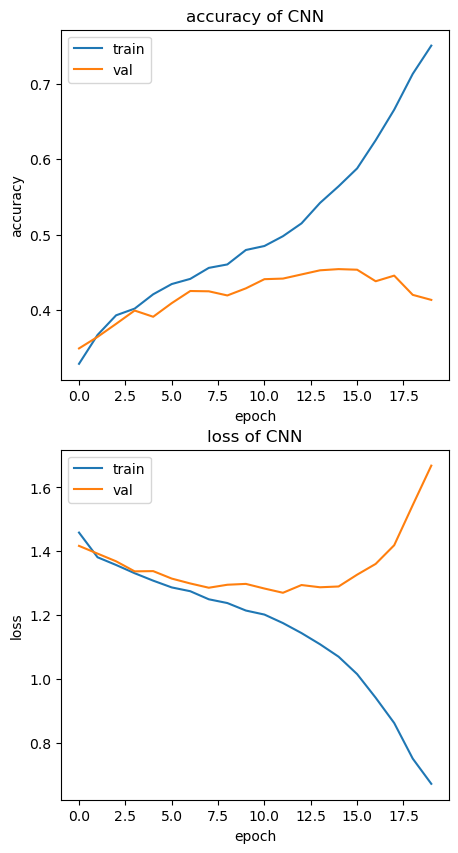

In [10]:
fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(*[2,1,1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
ax.set_title('accuracy of CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

ax = fig.add_subplot(*[2,1,2])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss of CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()